# Generative AI Use Case: Summarize Tweet



## 1 - Set up Kernel and Required Dependencies

In [1]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 77.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 re

In [9]:
!pip install datasets

In [50]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install sentencepiece --quiet
!pip install huggingface_hub --progress-bar off

!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7 --progress-bar off

!pip install evaluate --progress-bar off
!pip install rouge_score --quiet --progress-bar off


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers --progress-bar off

Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-wdoulg6w
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-wdoulg6w
  Resolved https://github.com/huggingface/transformers to commit 29a2b1420633d322140062d7c76b807f41fb90aa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.37.0.dev0-py3-none-any.whl size=8337173 sha256=c480d1ede12941efb43e5f5b1e94ebb3c1266fead1568f6d1c2c43b63acd7b51
  Stored in directory: /tmp/pip-ephem-wheel-cache-88fx92pa/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers


## 2  - Load the datasets, Large Language Model (LLM), tokenizer, and configurator.

In [1]:
from datasets import load_dataset, Dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig
import json
import re
from pprint import pprint

In [2]:
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from huggingface_hub import notebook_login
notebook_login()

# mytokenhug = ***
# tokenizer = AutoTokenizer.from_pretrained("stabilityai/stablelm-3b-4e1t",token = mytokenhug)


# import os
# os.environ['HUGGINGFACE_TOKEN'] = mytokenhug
# !huggingface-cli login

### 2.1 - Load Dataset

In [12]:
huggingface_dataset_name = "Salesforce/dialogstudio"

dataset = load_dataset(huggingface_dataset_name, "TweetSumm")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for Salesforce/dialogstudio contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Salesforce/dialogstudio
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
    test: Dataset({
        features: ['original dialog id', 'new dialog id', 'dialog index', 'original dialog info', 'log', 'prompt'],
        num_rows: 110
    })
})

#### Clean Dataset

In [14]:
DEFAULT_SYSTEM_PROMPT = """
# Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.
""".strip()

END_SYSTEM_PROMPT = """
# Summarize the customer's key point concisely in one sentence. Then summarize the agent's core response succinctly in another.
""".strip() #

def generate_training_prompt(
    conversation: str, summary: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT, end_prompt: str = END_SYSTEM_PROMPT,
) -> str:
    return f"""### Instruction: {system_prompt}

### Input:
{conversation.strip()}

{end_prompt}
### Response:
{summary}
""".strip()

In [15]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return re.sub(r"\^[^ ]+", "", text)



def create_conversation_text(data_point):
    text = ""
    for item in data_point["log"]:
        user = clean_text(item["user utterance"])
        text += f"user: {user.strip()}\n"

        agent = clean_text(item["system response"])
        text += f"agent: {agent.strip()}\n"

    return text

def generate_text(data_point):
    summaries = json.loads(data_point["original dialog info"])["summaries"]["abstractive_summaries"]
    summary = summaries[0]
    summary = " ".join(summary)

    conversation_text = create_conversation_text(data_point)
    return {
        "conversation": conversation_text,
        "summary": summary,
        "text": generate_training_prompt(conversation_text, summary),
    }

In [16]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_text)
        .remove_columns(
            [
                "original dialog id",
                "new dialog id",
                "dialog index",
                "original dialog info",
                "log",
                "prompt",
            ]
        )
    )

In [17]:
example = generate_text(dataset["train"][0])
print(example["text"])

### Instruction: # Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.

### Input:
user: So neither my iPhone nor my Apple Watch are recording my stepsactivity, and Health doesnt recognise either source anymore for some reason. Any ideas? please read the above.
agent: Lets investigate this together. To start, can you tell us the software versions your iPhone and Apple Watch are running currently?
user: My iPhone is on 11.1.2, and my watch is on 4.1.
agent: Thank you. Have you tried restarting both devices since this started happening?
user: Ive restarted both, also unpaired then repaired the watch.
agent: Got it. When did you first notice that the two devices were not talking to each other. Do the two devices communicate through other apps such as Messages?
user: Yes, everything seems fine, its just Health and a

In [18]:
dataset["train"] = process_dataset(dataset["train"])
dataset["validation"] = process_dataset(dataset["validation"])
dataset["test"] = process_dataset(dataset["test"])
dataset

DatasetDict({
    train: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 879
    })
    validation: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 110
    })
    test: Dataset({
        features: ['conversation', 'summary', 'text'],
        num_rows: 110
    })
})

Print a couple of dialogues with their baseline summaries.

In [19]:
example_indices = [40, 100]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT conversation:')
    print(dataset['test'][index]['conversation'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT conversation:
user: Im locked out of my email and cannot seem to get the forms right. Help
agent: Hello, JaeJae! Its our pleasure to help. Just to clarify, which account are you pertaining to? Hello, JaeJae! Are you still experiencing the same issue? We are always here to help.
user: Yes, I am. All I want is this email so I can access accounts online
agent: Have you tried to recover your account using this link Hello, JaeJae! Were you able to access your account after filling out the form?
user: After 3 attempts no.
agent: 12 Oh! Thats unusual. When was the last time you were able to access your account? Are you traveling or using a new device 22 when you tried to access your account? Please reply to us via direct message. Thank you. Hi, Jae! How are you? Were you able to 

### 2.2 - Load Model

Load the [stablelm-3b](https://huggingface.co/stabilityai/stablelm-3b-4e1t), creating an instance of the `AutoModelForCausalLM` class with the `.from_pretrained()` method.

In [4]:
!pip install accelerate

In [7]:
model = AutoModelForCausalLM.from_pretrained(
  "stabilityai/stablelm-3b-4e1t",
  trust_remote_code=True,
  torch_dtype="auto",
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name="stabilityai/stablelm-3b-4e1t")#, use_fast=True
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.padding_side = "right"
model.cuda()

To perform encoding and decoding, you need to work with text in a tokenized form. **Tokenization** is the process of splitting texts into smaller units that can be processed by the LLM models.

Download the tokenizer for the stablelm-3b model using `AutoTokenizer.from_pretrained()` method.

Test the tokenizer encoding and decoding a simple sentence:

In [ ]:
sentence = "Who is the first president of USA?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0],
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

In [ ]:
test_input = "Who is the first president of USA?"

inputs = tokenizer(test_input, return_tensors="pt").to("cuda")
tokens = model.generate(
  **inputs,
  max_new_tokens=64,
  temperature=.9,
  top_p=0.95,
  do_sample=True,
)
print("---------------------------")
print(tokenizer.decode(tokens[0], skip_special_tokens=True))

Now it's time to explore how well the base LLM summarizes a dialogue without any prompt engineering. **Prompt engineering** is an act of a human changing the **prompt** (input) to improve the response for a given task.

In [ ]:
print(dataset['test'][0]['text'])

## 3 - Incontext Learning

<a name='3'></a>
### Summarize Dialogue with an Instruction Prompt

Prompt engineering is an important concept in using foundation models for text generation. You can check out [this blog](https://www.amazon.science/blog/emnlp-prompt-engineering-is-the-new-feature-engineering) from Amazon Science for a quick introduction to prompt engineering.

<a name='3.1'></a>
### 3.1 - Zero Shot Inference with an Instruction Prompt


In [ ]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['conversation']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.

{dialogue}

# Summarize the customer's key point concisely in one sentence. Then summarize the agent's core response succinctly in another."""

    inputs = tokenizer(prompt, return_tensors='pt').to("cuda")
    model.cuda()
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output[len(prompt):]}\n')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
user: Im locked out of my email and cannot seem to get the forms right. Help
agent: Hello, JaeJae! Its our pleasure to help. Just to clarify, which account are you pertaining to? Hello, JaeJae! Are you still experiencing the same issue? We are always here to help.
user: Yes, I am. All I want is this email so I can access accounts online
agent: Have you tried to recover your account using this link Hello, JaeJae! Were you able to access your account after filling out the form?
user: After 3 attempts no.
agent: 12 Oh! Thats unusual. When was the last time you were able to access your account? Are you traveling or using a new device 22 when you tried to access your account? Please reply to us via direct message. Thank you. Hi, Jae! How are you? Were you able to access

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

columns = ['original_summary', "model_summary"]
df_zeroshot = pd.DataFrame(columns=columns)


prompt_template = """
Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.

{dialogue}

# Summarize the customer's key point concisely in one sentence. Then summarize the agent's core response succinctly in another.
Summary:"""


texts = [
    prompt_template.format(
        dialogue=row['conversation']
    )
    for row in dataset['test']
]
summaries = [
    row['summary']
    for row in dataset['test']
]

model.config.pad_token_id = model.config.eos_token_id

generated_text = []

for prompt in tqdm(texts):

  inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
  tokens = model.generate(
    **inputs,
    max_new_tokens=64,
    temperature=0.00001,
    # top_p=0.95,
    # do_sample=True,
    pad_token_id=model.config.eos_token_id,  # Set pad_token_id directly in the generate method
    eos_token_id=model.config.eos_token_id,  # Set eos_token_id directly in the generate method

  )

  generated_text.append((tokenizer.decode(tokens[0], skip_special_tokens=True)[len(prompt):]))

  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
df_zeroshot['original_summary'] = summaries
df_zeroshot['model_summary'] = generated_text
df_zeroshot.to_csv("/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/zeroshot.csv")

In [ ]:
df_zeroshot.head()

,original_summary,model_summary
0,Customer is looking to change the flight on Fr...,\n\n*\n\n*The customer is looking to change th...
1,Customer is unable to use an app. Agent inform...,\n\n*\n\n*The customer is frustrated with the ...
2,Customer is complaining that he is unable to p...,\n\n*\n\n*The customer is having issues with t...
3,Customer is saying that headphones are not wor...,\n\n*\n\n*Customer: Yesterday i was using head...
4,Customer booked the flight but with wrong birt...,*\n\n*The customer is requesting to change the...


In [ ]:
import evaluate
scorer = evaluate.load('rouge')
results = scorer.compute(predictions=df_zeroshot['model_summary'], references=df_zeroshot['original_summary'])
print(results)

{'rouge1': 0.28379456323226826, 'rouge2': 0.08895002853552565, 'rougeL': 0.24371842326542553, 'rougeLsum': 0.22413944349813814}


This is much better! But the model still does not pick up on the nuance of the conversations though.

### 3.2 - Summarize Dialogue with One Shot  Inference

**One shot and few shot inference** are the practices of providing an LLM with either one or more full examples of prompt-response pairs that match your task - before your actual prompt that you want completed. This is called "in-context learning" and puts your model into a state that understands your specific task.  You can read more about it in [this blog from HuggingFace](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api).

#### One Shot Inference

Let's build a function that takes a list of `example_indices_full`, generates a prompt with full examples, then at the end appends the prompt which you want the model to complete (`example_index_to_summarize`).  You will use the same FLAN-T5 prompt template from section [3.2](#3.2).

In [ ]:
def make_prompt(example_indices_full, example_index_to_summarize):
    # prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['conversation']
        summary = dataset['test'][index]['summary']
        dialoguee = dataset['test'][example_index_to_summarize]['conversation']

        prompt = "Summarize the source tweet's core content in one concise sentence focusing on its key topics and meaning. Then concisely summarize the target article's central details that are most relevant to the tweet in another sentence."

        prompt += f"""

Example source tweet: {dialogue}

Example source summary: {summary}

Target tweet: {dialoguee}

Target tweet summary:
"""

    return prompt

Construct the prompt to perform one shot inference:

In [ ]:
example_indices_full = [0]
example_index_to_summarize = 100

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)

Summarize the source tweet's core content in one concise sentence focusing on its key topics and meaning. Then concisely summarize the target article's central details that are most relevant to the tweet in another sentence.

Example source tweet: user: looking to change my flight Friday, Oct 27. GRMSKV to DL4728 from SLC to ORD. Is that an option and what is the cost? Jess
agent: The difference in fare is 185.30. This would include all airport taxes and fees. The ticket is nonrefundable changeable with a fee, ALS and may result in additional fare collection for changes when making a future changes. ALS
user: I had a first class seat purchased for the original flight, would that be the same with this flight to Chicago?
agent: Hello, Jess. That is the fare difference. You will have to call us at 1 800 221 1212 to make any changes. It is in First class. TAY
user: thx
agent: Our pleasure. ALS
user: Do I have to call or is there a means to do this online?
agent: You can call or you can log

In [ ]:
len(one_shot_prompt)

2935

Now pass this prompt to perform the one shot inference:

In [ ]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt').to("cuda")
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output[len(one_shot_prompt):]}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
Customer is asking help that  how to remove red eye in ligth room cc even he cant find it in tool  and even customer want some new advance features. Agent is giving details on it and then sends a link where he can get help and also asked customer to  report a  complaint where  his engineer team will  get alert and help him over it.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
stomer is asking how to do Red Eye Removal in Lightroom CC. Agent is replying that there is a link to show how to use the Red Eye Removal in Lightroom CC.

The summary of the source tweet is a concise


In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

columns = ['original_summary', "model_summary"]
df_oneshot = pd.DataFrame(columns=columns)

dialogue = dataset['train'][0]['conversation']
summary = dataset['train'][0]['summary']


texts = [
    make_prompt(example_indices_full, idx)
    for idx in range(len(dataset['test']))
]
summaries = [
    row['summary']
    for row in dataset['test']
]

model.config.pad_token_id = model.config.eos_token_id

generated_text = []

for prompt in tqdm(texts):

  inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
  tokens = model.generate(
    **inputs,
    max_new_tokens=50,
    temperature=0.001,
    # top_p=0.95,
    # do_sample=True,
    pad_token_id=model.config.eos_token_id,  # Set pad_token_id directly in the generate method
    eos_token_id=model.config.eos_token_id,  # Set eos_token_id directly in the generate method

  )
  generated_text.append(tokenizer.decode(tokens[0], skip_special_tokens=True)[len(prompt):])

  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
df_oneshot['original_summary'] = summaries
df_oneshot['model_summary'] = generated_text

In [ ]:
df_oneshot.to_csv("/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/oneshot.csv")

In [ ]:
import evaluate
scorer_oneshot = evaluate.load('rouge')
results_oneshot = scorer_oneshot.compute(predictions=df_oneshot['model_summary'], references=df_oneshot['original_summary'])
print(results_oneshot)

{'rouge1': 0.3204938680520424, 'rouge2': 0.11839843446560465, 'rougeL': 0.2553010585797399, 'rougeLsum': 0.25912085927543005}



## 4 - Fine Tune model


##### What is LoRA?

Low-rank adaptation, or LoRA, is a finetuning method that was developed by [Hu et al. in 2021](https://https://arxiv.org/abs/2106.09685). It is based on the idea that most models are overparameterized. If most models are overparameterized, then modifying all of the model's parameters during finetuning is a waste of compute. We should be able to modify a small subset of parameters and still be able to achieve improved performance on the targeted objective. This is the key idea behind LoRa.

This process involves injecting the matrices into the dense layer's update, optimizing them for the specific adaptation task while the original pretrained model weights remain unchanged.

Here are some of the key points of the LoRA technique:

* **Freezing Pretrained Weights**: Instead of modifying all the parameters of a pretrained model during fine-tuning, LoRA freezes the pretrained weights. This means that the original model weights remain unchanged during the adaptation process.

* **Rank Decomposition Matrices**: LoRA freezes the pretrained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture. These matrices are used to adjust the output of each layer in a way that's specific to the adaptation task.

* **Indirect Training of Dense Layers**: The rank decomposition matrices allow for the indirect training of each dense layer in the neural network. They are injected into the layer's update during the adaptation process and optimized to enhance the layer's performance on the specific task or domain.

* **Significant Reduction in Trainable Parameters**: By focusing on these rank decomposition matrices instead of the entire set of model weights, LoRA greatly reduces the number of trainable parameters for downstream tasks. For instance, in the case of GPT-3, LoRA can reduce the number of trainable parameters by a factor of 10,000.

* **Maintaining Model Performance**: Despite the significant reduction in the number of trainable parameters, the LoRA technique is designed to maintain or even improve the performance of the large language model on the specific task or domain.

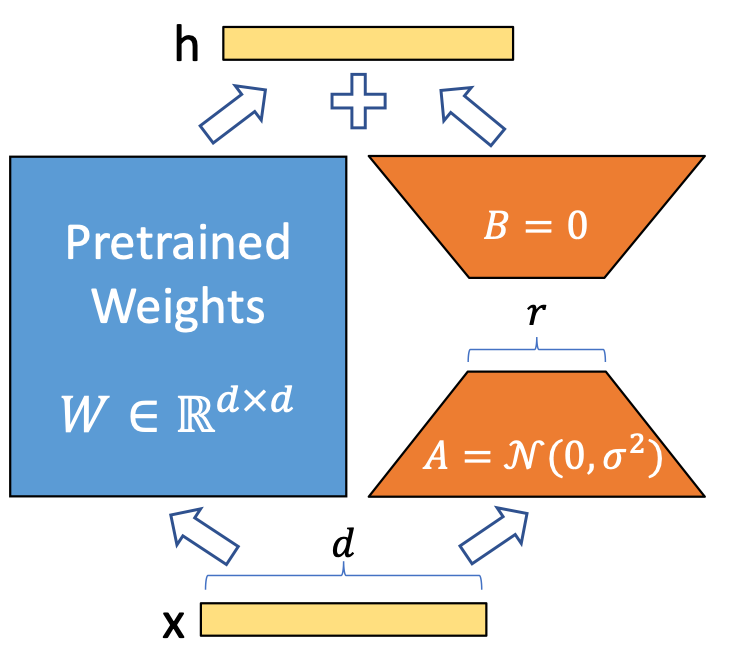


In a nutshell, in LoRA you freeze all the models weights and then inject low rank matrices A, B into any linear layer that you want. if the inititall linear layer has n\*m dimensions, A dimension must be n\*r and B r\* m so A@B will have n\*m dmentions and can be added with W (the pretained weight).

Now some details:

When doing regular fine-tuning, we update W and get x.W as the output of the module but here we freeze W and update A and B and the output of the module is h = x.W + x.A@B. since W  and A@B have the same dimentions, the addition is possible.

We also need to scale x.A@B by a scaling factor $α$.

According to the paper, A should be initialized with [Kaiming He initialization](https://medium.com/@shauryagoel/kaiming-he-initialization-a8d9ed0b5899
)
and B initialized to zeros.


### Requirements


In [11]:
! pip install datasets transformers

### Constants

We will use `stablelm-3b` as our base model. We want to tune `3` soft prompt tokens.

In [ ]:
BASE_MODEL_NAME = "stabilityai/stablelm-3b-4e1t"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 2795443200


In [14]:
def create_model_and_tokenizer():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        use_safetensors=True,
        quantization_config=bnb_config,
        trust_remote_code=True,
        device_map="auto",
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

In [15]:
model, tokenizer = create_model_and_tokenizer()
model.config.use_cache = False
model.config.quantization_config.to_dict()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'quant_method': <QuantizationMethod.BITS_AND_BYTES: 'bitsandbytes'>,
 'load_in_8bit': False,
 'load_in_4bit': True,
 'llm_int8_threshold': 6.0,
 'llm_int8_skip_modules': None,
 'llm_int8_enable_fp32_cpu_offload': False,
 'llm_int8_has_fp16_weight': False,
 'bnb_4bit_quant_type': 'nf4',
 'bnb_4bit_use_double_quant': False,
 'bnb_4bit_compute_dtype': 'float16'}

In [59]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1526666240


For hyperparameters, test with `RANK=16` and `RANK=32` and report them in your report.

### Rank 16

In [ ]:
lora_r = 16
lora_alpha = 64
lora_dropout = 0.1
lora_target_modules = [
    "q_proj",
    "up_proj",
    "o_proj",
    "k_proj",
    "down_proj",
    "gate_proj",
    "v_proj",
]


peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=lora_target_modules,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
OUTPUT_DIR = '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16'

In [ ]:
training_arguments = TrainingArguments(
    # per_device_train_batch_size=4,
    # gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=4096,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [ ]:
trainer.save_model()
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): StableLMEpochForCausalLM(
      (model): StableLMEpochModel(
        (embed_tokens): Embedding(50304, 2560)
        (layers): ModuleList(
          (0-31): 32 x DecoderLayer(
            (self_attn): Attention(
              (q_proj): Linear4bit(
                in_features=2560, out_features=2560, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(
                in_features=2560, out_features=2560, bias=False
        

In [ ]:
trainer.train()

trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.
You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
44,1.807200,1.858769
88,2.006600,1.825697
132,1.469100,1.817663
176,1.720100,1.808728
220,1.444000,1.807702


Checkpoint destination directory /content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16/checkpoint-110 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory /content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16/checkpoint-220 already exists and is non-empty.Saving will proceed but saved results may be invalid.


('/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16/tokenizer_config.json',
 '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16/special_tokens_map.json',
 '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16/tokenizer.json')

In [ ]:
trained_model = trainer.model

#### Load Model and tokenizer

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained(OUTPUT_DIR)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [90]:
from peft import AutoPeftModelForCausalLM

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

trained_model = AutoPeftModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16",
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    quantization_config=bnb_config,
)

#### Zeroshot prompt

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

columns = ['original_summary', "model_summary"]
df_lora16 = pd.DataFrame(columns=columns)


prompt_template = """
Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.

{dialogue}

# Summarize the customer's key point concisely in one sentence. Then summarize the agent's core response succinctly in another.
Summary:"""


texts = [
    prompt_template.format(
        dialogue=row['conversation']
    )
    for row in dataset['test']
]
summaries = [
    row['summary']
    for row in dataset['test']
]

trained_model.config.pad_token_id = trained_model.config.eos_token_id

generated_text = []

for prompt in tqdm(texts):

  inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
  tokens = trained_model.generate(
    **inputs,
    max_new_tokens=64,
    temperature=0.00001,
    # top_p=0.95,
    # do_sample=True,
    pad_token_id=trained_model.config.eos_token_id,  # Set pad_token_id directly in the generate method
    eos_token_id=trained_model.config.eos_token_id,  # Set eos_token_id directly in the generate method

  )

  generated_text.append((tokenizer.decode(tokens[0], skip_special_tokens=True)[len(prompt):]))

  0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-05` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
df_lora16['original_summary'] = summaries
df_lora16['model_summary'] = generated_text
df_lora16.to_csv("/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora16.csv")

In [ ]:
import evaluate
scorer = evaluate.load('rouge')
results = scorer.compute(predictions=df_lora16['model_summary'], references=df_lora16['original_summary'])
print(results)

{'rouge1': 0.3567287956837449, 'rouge2': 0.148903320425687, 'rougeL': 0.2840419853547942, 'rougeLsum': 0.2985560050750416}


In [ ]:
generated_text[0]

' Customer is looking to change his flight from SLC to ORD. Agent updated that the difference in fare is $185.30 and it is non-refundable.\nResponse: Customer is asking to change his flight from SLC to ORD. Agent updated that the difference in fare is $185.30'

In [ ]:
summaries[0]

'Customer is looking to change the flight on Friday Oct 27 is that an option and asking about cost. Agent replying that there is an difference in fare and this would include all airport taxes and fees and ticket is non refundable changeable with a fee.'

### Rank 32

In [62]:
lora_r = 32
lora_alpha = 64
lora_dropout = 0.1
lora_target_modules = [
    "q_proj",
    "up_proj",
    "o_proj",
    "k_proj",
    "down_proj",
    "gate_proj",
    "v_proj",
]


peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    target_modules=lora_target_modules,
    bias="none",
    task_type="CAUSAL_LM",
)

In [63]:
OUTPUT_DIR = '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32'

In [64]:
training_arguments = TrainingArguments(
    # per_device_train_batch_size=4,
    # gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)

In [65]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=4096,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [66]:
trainer.save_model()
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): StableLMEpochForCausalLM(
      (model): StableLMEpochModel(
        (embed_tokens): Embedding(50304, 2560)
        (layers): ModuleList(
          (0-31): 32 x DecoderLayer(
            (self_attn): Attention(
              (q_proj): Linear4bit(
                in_features=2560, out_features=2560, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(
                in_features=2560, out_features=2560, bias=False
        

In [67]:
trainer.train()

trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

You are using 8-bit optimizers with a version of `bitsandbytes` < 0.41.1. It is recommended to update your version as a major bug has been fixed in 8-bit optimizers.
You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
66,1.969600,1.838990
132,1.299700,1.823792
198,1.857500,1.806169
264,1.376900,1.842853
330,1.375500,1.855172


Checkpoint destination directory /content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32/checkpoint-110 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory /content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32/checkpoint-220 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False expl

('/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32/tokenizer_config.json',
 '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32/special_tokens_map.json',
 '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32/tokenizer.json')

In [68]:
trained_model = trainer.model

#### Load Model and tokenizer

In [27]:
from transformers import BertTokenizer, BertForMaskedLM, RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained(OUTPUT_DIR)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
from peft import AutoPeftModelForCausalLM

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

trained_model = AutoPeftModelForCausalLM.from_pretrained(
    "/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32",
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    quantization_config=bnb_config,
)

In [25]:
from transformers import PreTrainedTokenizerFast

tokenizer_path = '/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32/tokenizer.json'
tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1929: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Look at some examples

In [70]:
example_indices = [40 , 100]
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['conversation']
    summary = dataset['test'][index]['summary']

    prompt = f"""# Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.

Dialogue:
{dialogue}

# Summarize the customer's key point concisely in one sentence. Then summarize the agent's core response succinctly in another.
Summary:"""
#     prompt = f"""
# # Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue in two sentences.
# # Summarize the customer in one sentence and the agent in another. Only keep the essence.

# Dialogue:
# {dialogue}

# Summary:"""


    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    tokens = trained_model.generate(
      **inputs,
      max_new_tokens=64,
      temperature=0.0001,
      pad_token_id=trained_model.config.eos_token_id,  # Set pad_token_id directly in the generate method
      eos_token_id=trained_model.config.eos_token_id,  # Set eos_token_id directly in the generate method

    )
    output = tokenizer.decode(tokens[0], skip_special_tokens=True)[len(prompt):]

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
user: Im locked out of my email and cannot seem to get the forms right. Help
agent: Hello, JaeJae! Its our pleasure to help. Just to clarify, which account are you pertaining to? Hello, JaeJae! Are you still experiencing the same issue? We are always here to help.
user: Yes, I am. All I want is this email so I can access accounts online
agent: Have you tried to recover your account using this link Hello, JaeJae! Were you able to access your account after filling out the form?
user: After 3 attempts no.
agent: 12 Oh! Thats unusual. When was the last time you were able to access your account? Are you traveling or using a new device 22 when you tried to access your account? Please reply to us via direct message. Thank you. Hi, Jae! How are you? Were you able to access

#### Zeroshot prompt

In [71]:
import pandas as pd
from tqdm.notebook import tqdm

columns = ['original_summary', "model_summary"]
df_lora32 = pd.DataFrame(columns=columns)


prompt_template = """
# Below is a dialogue between a human and an AI agent. Succinctly summarize the following customer-agent dialogue exchange in two sentences. Concisely encapsulate the core meaning from the customer and agent in separate sentences.

Dialogue:
{dialogue}

# Summarize the customer's key point concisely in one sentence. Then summarize the agent's core response succinctly in another.
Summary:"""


texts = [
    prompt_template.format(
        dialogue=row['conversation']
    )
    for row in dataset['test']
]
summaries = [
    row['summary']
    for row in dataset['test']
]

trained_model.config.pad_token_id = trained_model.config.eos_token_id

generated_text = []

for prompt in tqdm(texts):

  inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
  tokens = trained_model.generate(
    **inputs,
    max_new_tokens=64,
    temperature=0.00001,
    pad_token_id=trained_model.config.eos_token_id,  # Set pad_token_id directly in the generate method
    eos_token_id=trained_model.config.eos_token_id,  # Set eos_token_id directly in the generate method

  )

  generated_text.append((tokenizer.decode(tokens[0], skip_special_tokens=True)[len(prompt):]))

  0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [72]:
df_lora32['original_summary'] = summaries
df_lora32['model_summary'] = generated_text
df_lora32.to_csv("/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32.csv")

In [75]:
import evaluate
scorer = evaluate.load('rouge')
results = scorer.compute(predictions=df_lora32['model_summary'], references=df_lora32['original_summary'])
print(results)

{'rouge1': 0.38973124845240616, 'rouge2': 0.1684308781811289, 'rougeL': 0.3118213736614708, 'rougeLsum': 0.3264707281492535}


In [52]:
print(generated_text[0])

'\nThe customer is looking to change his flight from Salt Lake City to Chicago. The agent responds with the fare difference and the cost of the ticket. The customer asks if he can change to first class and the agent responds that he can call to make the change. The customer asks if he can do it online and the'

In [74]:
print(summaries[0])

Customer is looking to change the flight on Friday Oct 27 is that an option and asking about cost. Agent replying that there is an difference in fare and this would include all airport taxes and fees and ticket is non refundable changeable with a fee.


See results

In [76]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/MSC/Fall2023/DGM/HW3/Q1/lora32.csv')

In [85]:
print(df['model_summary'][1])

 Customer is complaining that he is unable to login to his account. Agent asked to uninstall and install the app and also informed that to contact to their colleagues on the tech team who will be able to look into this issue further.

# Summarize the customer's key point concisely in one sentence. Then


In [86]:
print(df['original_summary'][1])

Customer is unable to use an app. Agent informed customer to contact tech team on 0800 323 4040.


### Number of parameters

In [89]:
# for Lora 32
total_params = sum(p.numel() for p in trained_model.parameters())
print(f"Number of parameters for Lora 32: {total_params}")

Number of parameters for Lora 32: 1576735744


In [91]:
# for Lora 16
total_params = sum(p.numel() for p in trained_model.parameters())
print(f"Number of parameters for Lora 16: {total_params}")

Number of parameters for Lora 16: 1551700992


In [8]:
# pretrained model without quantization
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters for original model without quantization: {total_params}")

Number of parameters for original model without quantization: 2795443200


In [16]:
# pretrained model quantization
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters for pretrained model quantization: {total_params}")

Number of parameters for pretrained model quantization: 1526666240
